# Forest Fire Incidence in Northern Algeria: Proposal

In [3]:
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [4]:
set.seed(38)

## Introduction

Northern Algeria has high wildfire activity, experiencing 32 204 forest fires between 2001 and 2019 (Curt et. al., 2020). 

Daily temperature, relative humidity, rainfall, wind speed, and Fire Weather Index (FWI) data were collected in the Bejaia and Sidi Bel Abbes regions of Northern Algeria from June to September in 2012. FWI is divided into two categories (De Groot, 1987). Fuel moisture codes (FFMC, DMC, and DC) represent ratings of moisture for specific fuel depths. Fire behaviour indices include Initial Spread Index (ISI), expected rate of fire spread, Buildup Index (BUI), amount of fuel available, and Fire Weather Index, expected fire intensity.

Our goal is to answer: Can we predict whether a region in Northern Algeria will experience a forest fire based upon bioclimatic conditions?


## Preliminary Exploratory Data Analysis

In [5]:
## Load datasets from URL

algerian_forest_fire_Bejaia <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", 
                                 skip = 1, n_max = 122) %>%
    mutate(Region = "Bejaia")

algerian_forest_fire_Sidi_Bel_Abbes <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv",
                                               skip = 126) %>%
    mutate(Region = "Sidi Bel Abbes")

## Merge datasets of the two regions

algeria_forest_fire_all_data <- rbind(algerian_forest_fire_Bejaia, algerian_forest_fire_Sidi_Bel_Abbes) %>%
    mutate(Classes = as_factor(Classes)) %>%
    mutate(Region = as_factor(Region))

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_character(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“1 parsing failure.
row col   expected     actual                                                                                                       file
 44  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-lear

In [6]:
## Manually set values of incorrect column, convert DC and FWI to numeric type

algeria_forest_fire_all_data[166, 10] <- '14.6'
algeria_forest_fire_all_data[166, 11] <- 9
algeria_forest_fire_all_data[166, 12] <- 12.5
algeria_forest_fire_all_data[166, 13] <- '10.4'
algeria_forest_fire_all_data[166, 14] <- "fire" 

algeria_forest_fire_all_data <- algeria_forest_fire_all_data %>%
    mutate(DC = as.numeric(DC)) %>%
    mutate(FWI = as.numeric(FWI))

# ## Create date column
# algeria_forest_fire_all_data <- algeria_forest_fire_all_data %>%
#     mutate(date = as.Date(paste(year, month, day, sep='-')))

In [7]:
## Create training dataset

forest_fire_split <- algeria_forest_fire_all_data %>%
    select(Temperature, RH, Rain, FFMC, Classes) %>%
    initial_split(prop = 0.65, strata = Classes)
forest_fire_train <- training(forest_fire_split)
forest_fire_test <- testing(forest_fire_split)

forest_fire_train

Temperature,RH,Rain,FFMC,Classes
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,57,0.0,65.7,not fire
29,61,1.3,64.4,not fire
26,82,13.1,47.1,not fire
25,89,2.5,28.6,not fire
⋮,⋮,⋮,⋮,⋮
30,65,0.0,85.4,fire
28,87,4.4,41.1,not fire
27,87,0.5,45.9,not fire
24,54,0.1,79.7,not fire


The following table summarizes the predictors’ means and the number of observations for each of the classes. The classes are approximately balanced, with more observations of fire. Days with fire display higher mean temperatures, lower mean relative humidity, higher mean FFMC, and lower mean rainfall.

In [8]:
## Explore means of predictor variables and the number of observations in each category

means <- forest_fire_train %>%
    group_by(Classes) %>%
    summarize(mean_temp = mean(Temperature),
             mean_RH = mean(RH),
             mean_rain = mean(Rain),
             mean_FFMC = mean(FFMC),
             obs_count = n())

means

`summarise()` ungrouping output (override with `.groups` argument)



Classes,mean_temp,mean_RH,mean_rain,mean_FFMC,obs_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
not fire,29.75362,69.92754,1.65652174,64.85072,69
fire,33.85556,56.26667,0.04888889,87.47889,90


In [9]:
options(repr.plot.width = 8, repr.plot.height = 6)

Next, we compare the distribution of the predictors between the 2 classes, examining differences which might suggest how each variable relates to fire incidence by constructing histograms for each predictor.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



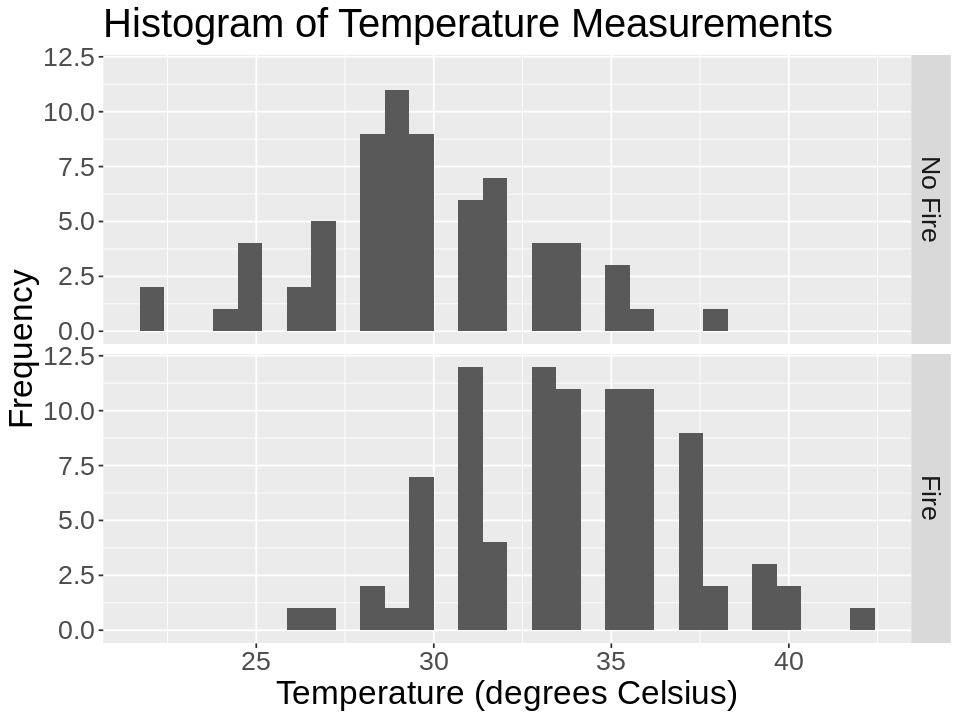

In [13]:
# Plot distribution of 'temperature' predictor on days with and without fire
Classes.labs <- c("No Fire", "Fire")
names(Classes.labs) <- c("not fire", "fire")


temp_distribution_plot_fire <- forest_fire_train %>%
    ggplot(aes(x = Temperature)) +
    geom_histogram() +
    labs(x = "Temperature (degrees Celsius)", y = "Frequency", title = "Histogram of Temperature Measurements") +
    facet_grid(Classes ~ ., labeller = labeller(Classes = Classes.labs)) +
    theme(text = element_text(size = 20))

temp_distribution_plot_fire

This histogram supports that higher temperatures may be related to fire, since the distribution for the "fire" class is centered approximately 5°C higher.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



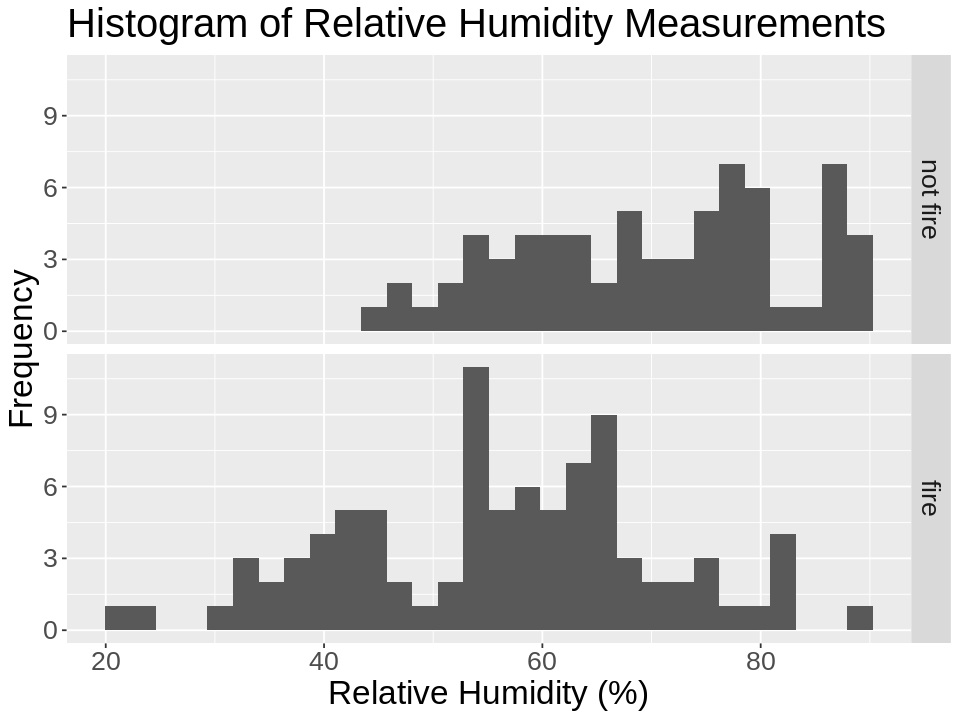

In [14]:
## Plot distribution of 'relative humidity' predictor on days with and without fire

RH_distribution_plot_fire <- forest_fire_train %>%
    ggplot(aes(x = RH)) +
    geom_histogram() +
    labs(x = "Relative Humidity (%)", y = "Frequency", title = "Histogram of Relative Humidity Measurements") +
    facet_grid(Classes ~ .) +
    theme(text = element_text(size = 20))

RH_distribution_plot_fire

Days with no fire have consistently higher relative humidity, whereas relative humidity varies greatly on days with fires.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



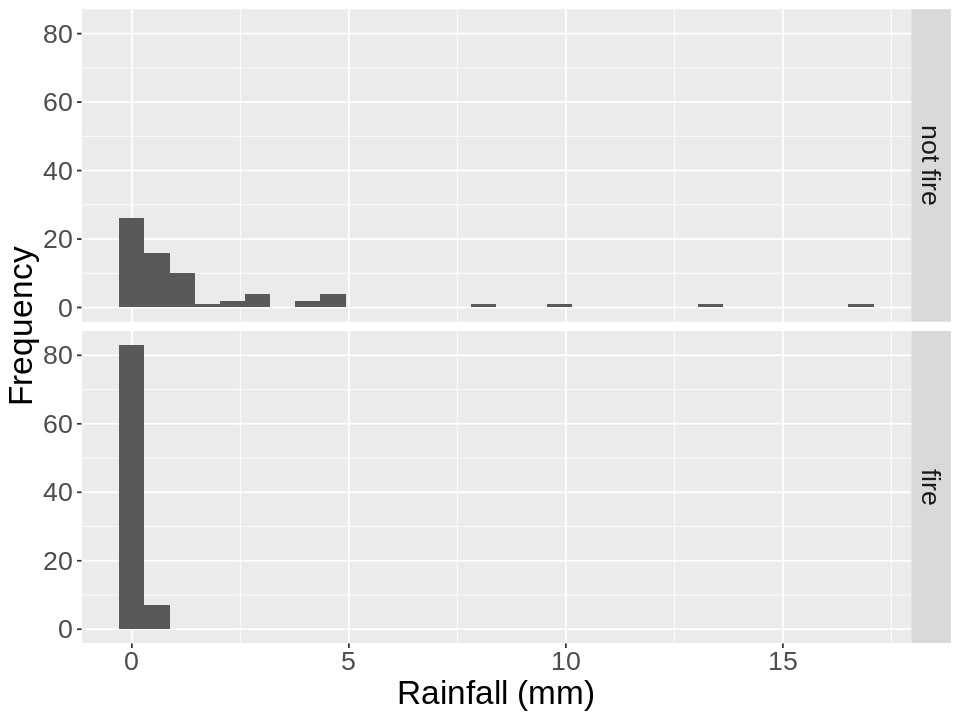

In [37]:
## Plot distribution of 'rainfall' predictor on days with and without fire

rain_distribution_plot_fire <- forest_fire_train %>%
    ggplot(aes(x = Rain)) +
    geom_histogram() +
    labs(x = "Rainfall (mm)", y = "Frequency") +
    facet_grid(Classes ~ .) +
    theme(text = element_text(size = 20))

rain_distribution_plot_fire

Days with fire have minimal rainfall, whereas rainfall varies from 0 to 20 mm on days without fire.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



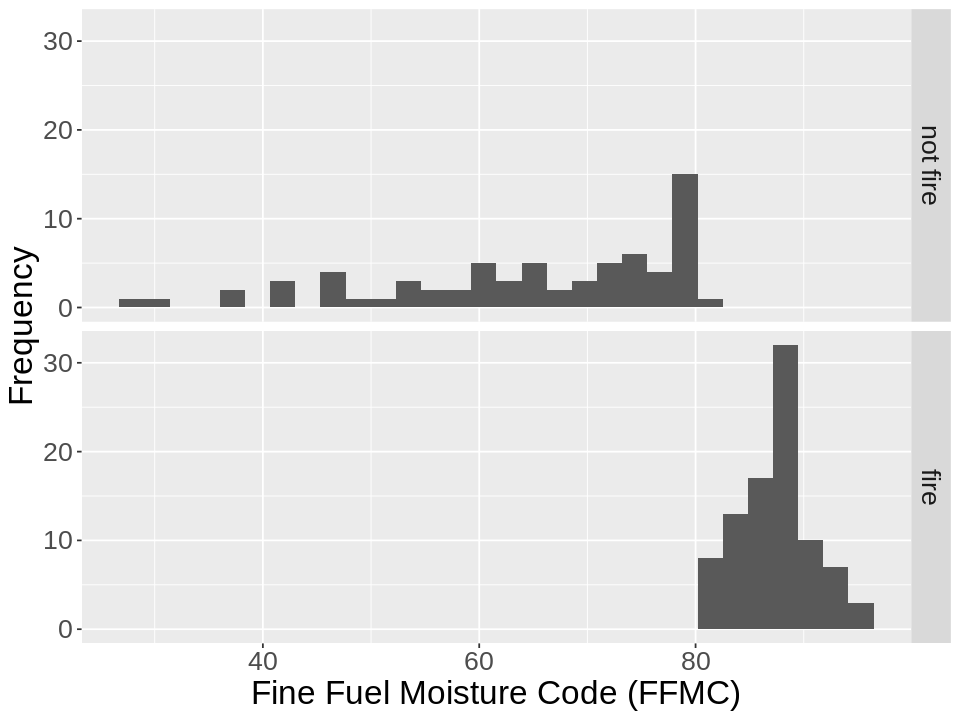

In [38]:
## Plot distribution of 'Fine Fuel Moisture Code' predictor on days with and without fire

FFMC_distribution_plot_fire <- forest_fire_train %>%
    ggplot(aes(x = FFMC)) +
    geom_histogram() +
    labs(x = "Fine Fuel Moisture Code (FFMC)", y = "Frequency") +
    facet_grid(Classes ~ .) +
    theme(text = element_text(size = 20))

FFMC_distribution_plot_fire

For all classifications of “fire,” FFMC is greater than 80. This suggests that FFMC may be an excellent predictor of fire, with FFMC ≈ 80 separating the two classes.

In [39]:
options(repr.plot.width = 7, repr.plot.height = 6)

## Methods

We plan to use a k-nearest neighbours classification algorithm with cross-validation to predict whether there will be a fire on a given day. As BUI, ISI, and FWI, characterize fire behaviour, we decided that they would not be helpful in predicting the fire likelihood.  From the exploratory analysis, patterns appear in the values of temperature, humidity, rain, and FFMC based upon the fire classification; therefore, these will be the variables included in our algorithm. The results will be shown with scatterplots of the data, the predictors as axes, and colored by classification.

## Expected Outcomes and Significance

We anticipate that FFMC will be the strongest predictor of fire due to the distinct separation in values observed in the histogram. It is expected that higher temperature, lower humidity, and minimal rain correspond to an incident of fire. 

Our findings may assist in determining whether a fire will occur based on bioclimatic conditions. This knowledge could improve interventions to prevent forest fires, protecting the ecosystems and residents of these regions.

The causes of forest fires in Algeria are widely unknown; in 2020, causation for 85% of fires were unknown (Pons, 2020). However, our data analysis could lead to asking whether rainfall, temperature, humidity, or FFMC has a direct causality to fire incidence.

## References

Aini, A., Curt, T., Bekdouche, F. (2020). Modelling fire hazard in the southern Mediterranean fire rim (Bejaia region, northern Algeria). Retrieved March 03, 2021, from
https://link.springer.com/article/10.1007/s10661-019-7931-0#Sec1

Curt, T., Aini, A., Dupire, S. (2020). Fire activity in Mediterranean forests (The Algerian case). Retrieved March 03, 2021, from
https://www.mendeley.com/catalogue/0ad59940-c469-388c-8796-0685cacb334f/

De Groot, W. J. (1987, April 2). Interpreting the Canadian Forest Fire Weather Index (FWI) System. Retrieved March 03, 2021, from
http://www.dnr.state.mi.us/WWW/FMD/WEATHER/Reference/FWI_Background.pdf

Pons, J. (2020, June 29). Algeria declares land and space war on forest fires. Retrieved March 03, 2021, from https://atalayar.com/en/content/algeria-declares-land-and-space-war-forest-fires